# Project Intro
For this project, we were given the West Nile Virus Predicition Challenge from Kaggle https://www.kaggle.com/c/predict-west-nile-virus/ and tasked with 1) predicting the presence of West Nile over the prediction data set (over 116,000 rows), 2) create a cost benefit analysis on the effectiveness of spraying, and 3) present in class with our findings. This was our first group project and I really enjoyed the experience of collaborating with my classmates to strategize our plan and execute it together. 

Below, I’ve provided code for the first objective around predicting West Nile Virus. Most of the this was written by myself except where I’ve indicated below. This task was especially challenging based on a number of factors, including 1) unbalanced classes (roughly 5% of samples were positive for West Nile Virus, 2) data availability (we were provided the number of mosquitos per trap and spraying information only for the training samples), and 3) low correlation between features and target. Below, I’ve detailed our approach to dealing with each of these factors.

Some parts of this project that I really enjoyed were the advanced feature engineering tasks and designing features based on background research, dealing with time and location data, resampling to deal with the unbalanced classes, imputing missing data with fancyimpute (wasn’t really necessary but I wanted to gain experience with this package), implementing a pipeline to deal with both continuous and categorical features, and the advanced models used. I also got to play around with Uber's new, open-source Kepler.gl tool for plotting some of the time series data. I've included a screenshot of one of the maps I made below and can send you the file upon request (unfortuately, no way to embed the map yet but you can upload a copy of the ones I've made to see get a feel for the data yourself).

I hope you enjoy reading through my code and explanations as much as I did working on this project! As always, feel free to reach out with any questions or comments.

!['West Nile Virus Presence by Month'](movie3.gif)

![title](./map.png)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, LabelEncoder, LabelBinarizer, MinMaxScaler
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import DBSCAN, KMeans
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import confusion_matrix, roc_auc_score, auc, roc_curve, recall_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from imblearn.ensemble import BalancedBaggingClassifier 
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN 
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import EditedNearestNeighbours 
import numpy as np
from scipy import stats
import seaborn as sns
import tensorflow as tf
from sklearn import metrics
from datetime import datetime
import xgboost as xgb
import pickle
from fancyimpute import MICE, KNN

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_data = pd.read_csv('train.csv')
weather_data = pd.read_csv('weather.csv')
spray_data = pd.read_csv('spray.csv')
predict_data = pd.read_csv('test.csv')

# Data Exploration

Training and prediction data sets contain information from mosquito traps around Chicago, with data, location, and species data for each. Training data set has two additional features compared with the prediction data set - a count of mosquistos and whether West Nile Virus is present. Training data set contains odd years from 2007 to 2013 while prediction data set is even years from 2008 to 2014. Months included are summer and fall months. Weather data has data for all years from two weather stations in Chicago. Spray data is pretty limited, containing only two years (2011 & 2013) and ten days of spraying. No indication that this is the complete spray data for each year. 

In [3]:
train_data.describe(include='all')

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
count,10506,10506,10506,10506.000000,10506,10506,10506,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000
unique,95,138,7,NaN,128,136,138,NaN,NaN,NaN,NaN,NaN
top,2007-08-01,"ORD Terminal 5, O'Hare International Airport, ...",CULEX PIPIENS/RESTUANS,NaN,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",NaN,NaN,NaN,NaN,NaN
freq,551,750,4752,NaN,750,750,750,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,35.687797,NaN,NaN,NaN,41.841139,-87.699908,7.819532,12.853512,0.052446
std,NaN,NaN,NaN,24.339468,NaN,NaN,NaN,0.112742,0.096514,1.452921,16.133816,0.222936
min,NaN,NaN,NaN,10.000000,NaN,NaN,NaN,41.644612,-87.930995,3.000000,1.000000,0.000000
25%,NaN,NaN,NaN,12.000000,NaN,NaN,NaN,41.732984,-87.760070,8.000000,2.000000,0.000000
50%,NaN,NaN,NaN,33.000000,NaN,NaN,NaN,41.846283,-87.694991,8.000000,5.000000,0.000000
75%,NaN,NaN,NaN,52.000000,NaN,NaN,NaN,41.954690,-87.627796,9.000000,17.000000,0.000000


In [4]:
predict_data.describe(include='all')

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
count,116293.000000,116293,116293,116293,116293.000000,116293,116293,116293,116293.000000,116293.000000,116293.000000
unique,NaN,95,151,8,NaN,139,149,151,NaN,NaN,NaN
top,NaN,2012-07-09,"ORD Terminal 5, O'Hare International Airport, ...",CULEX PIPIENS/RESTUANS,NaN,N OAK PARK AVE,T009,"1000 W OHARE AIRPORT, Chicago, IL",NaN,NaN,NaN
freq,NaN,1293,1468,15359,NaN,1617,1528,1468,NaN,NaN,NaN
mean,58147.000000,NaN,NaN,NaN,41.131100,NaN,NaN,NaN,41.849389,-87.693658,7.954357
std,33571.041765,NaN,NaN,NaN,24.864726,NaN,NaN,NaN,0.106593,0.080699,1.252733
min,1.000000,NaN,NaN,NaN,10.000000,NaN,NaN,NaN,41.644612,-87.930995,3.000000
25%,29074.000000,NaN,NaN,NaN,18.000000,NaN,NaN,NaN,41.753411,-87.750938,8.000000
50%,58147.000000,NaN,NaN,NaN,39.000000,NaN,NaN,NaN,41.862292,-87.694991,8.000000
75%,87220.000000,NaN,NaN,NaN,61.000000,NaN,NaN,NaN,41.951866,-87.648860,9.000000


# Clean data and feature engineering - weather data

Weather data has some null values (represented by 'M') and some features that aren't relevant and can be dropped (e.g. 'SnowFall'). Also has many columns as object data types that will need to be converted to float. Weather data represents the bulk to the data available for both training and predicition data sets so will be the focus of my feature engineering. I will explore features such as rolling averages, time-lagged data, and categorizing light and heavy rain days. I will create these features in the original data set before merging, as after merging some weather data will be removed because the training and prediction data sets have readings for only specific days. 

In [5]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
Station        2944 non-null int64
Date           2944 non-null object
Tmax           2944 non-null int64
Tmin           2944 non-null int64
Tavg           2944 non-null object
Depart         2944 non-null object
DewPoint       2944 non-null int64
WetBulb        2944 non-null object
Heat           2944 non-null object
Cool           2944 non-null object
Sunrise        2944 non-null object
Sunset         2944 non-null object
CodeSum        2944 non-null object
Depth          2944 non-null object
Water1         2944 non-null object
SnowFall       2944 non-null object
PrecipTotal    2944 non-null object
StnPressure    2944 non-null object
SeaLevel       2944 non-null object
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null int64
AvgSpeed       2944 non-null object
dtypes: float64(1), int64(5), object(16)
memory usage: 506.1+ KB


In [6]:
for i in weather_data.columns: #iterate through each column
    if i not in ['Date', 'CodeSum', 'Station']: #ignore these columns for now (want to convert the rest to floats)
        weather_data[i].replace('M', np.nan, inplace=True) #'M' means missing
        weather_data[i].replace('-', 0, inplace=True) #'-' is 0
        weather_data[i].replace('  T', 0.005, inplace=True) #'T' is trace 
        weather_data[i] = weather_data[i].astype('float') #covert to float

In [7]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
Station        2944 non-null int64
Date           2944 non-null object
Tmax           2944 non-null float64
Tmin           2944 non-null float64
Tavg           2933 non-null float64
Depart         1472 non-null float64
DewPoint       2944 non-null float64
WetBulb        2940 non-null float64
Heat           2933 non-null float64
Cool           2933 non-null float64
Sunrise        2944 non-null float64
Sunset         2944 non-null float64
CodeSum        2944 non-null object
Depth          1472 non-null float64
Water1         0 non-null float64
SnowFall       1472 non-null float64
PrecipTotal    2942 non-null float64
StnPressure    2940 non-null float64
SeaLevel       2935 non-null float64
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null float64
AvgSpeed       2941 non-null float64
dtypes: float64(19), int64(1), object(2)
memory usage: 506.1+ KB


In [8]:
weather_data.isnull().sum().sort_values(ascending=False) #check for null values

Water1         2944
Depart         1472
SnowFall       1472
Depth          1472
Tavg             11
Cool             11
Heat             11
SeaLevel          9
StnPressure       4
WetBulb           4
AvgSpeed          3
PrecipTotal       2
Date              0
Tmax              0
Tmin              0
Sunrise           0
DewPoint          0
ResultDir         0
Sunset            0
CodeSum           0
ResultSpeed       0
Station           0
dtype: int64

In [9]:
weather_data.drop(['Depart','CodeSum','Depth','Water1','SnowFall'], axis=1, inplace=True) #drop irrelevant and/or columns with a lot of missing data

In [10]:
#try fancyimput to fill missing values (not really necessary, but good to know how to do this)
mask = weather_data.isnull().any(axis=1) #set up mask for rows with missing data
cols = [cols for cols in weather_data.columns if weather_data[cols].isnull().any() == True] #get columns with missing data
nanvalues = KNN(k=3, verbose=False).complete(weather_data.loc[mask, cols]) #use fancyimpute with KNN to generate replacements for missing values
weather_data.loc[mask, cols] = nanvalues #fill in missing data with new values

In [11]:
assert weather_data.isnull().sum().sum() == 0 #check to make sure there is no more missing data

In [12]:
#generate a feature for humidity (function written by a teammate)

def humidity(Tf, Tdf):

    # convert temp to celsius
    Tc=5.0/9.0*(Tf-32.0)
    # convert dewpoint temp to celsius
    Tdc=5.0/9.0*(Tdf-32.0)
    # saturation vapor pressure
    Es=6.11*10.0**(7.5*Tc/(237.7+Tc))
    # actual vapor pressure
    E=6.11*10.0**(7.5*Tdc/(237.7+Tdc))
    #relative humidity
    RH =(E/Es)*100
        
    return RH

weather_data["RelHum"] = humidity(weather_data['Tavg'],weather_data['DewPoint'])

In [13]:
#create datetime object for date
weather_data['Date'] = pd.to_datetime(weather_data['Date'])

#calculate day length
weather_data['day_length'] = weather_data['Sunset'] - weather_data['Sunrise']

#create list of features that are not date or codesum
weather_feature_cols = [cols for cols in weather_data.columns if weather_data[cols].dtype in [float, int]]

#computer rolling averages 
for i in [3,5,10,14,21,30]: #set intervals for rolling average calculation
    for j in weather_feature_cols:
        weather_data[j + '_rolling_' + str(i)] = weather_data[j].rolling(window=i).mean() #create column with interval for each computation                                                             

#create shifted columns
for i in range(1,15):
    for j in weather_feature_cols:
        weather_data[j + '_shift_' + str(i)] = weather_data[j].shift(periods=i)

#create columns for light and heavy rain days based on quantile of rainy days
precip_50quantile = weather_data[weather_data['PrecipTotal'] > 0]['PrecipTotal'].quantile(.5) #heavy rain day defined as 50th quantile or above of rainy days
precip_10quantile = weather_data[weather_data['PrecipTotal'] > 0]['PrecipTotal'].quantile(.1) #light rain day defined as 50th quantile or above of rainy days

weather_data['heavy_rain'] = (weather_data['PrecipTotal']>precip_50quantile).astype(int)
weather_data['light_rain'] = ((weather_data['PrecipTotal']>0) & (weather_data['PrecipTotal']<precip_10quantile)).astype(int)

light_rain_col_list = []
heavy_rain_col_list = []
for i in range(1,15):
    weather_data['light_rain_' + str(i) + '_days_ago'] = weather_data['light_rain'].shift(periods=i)
    weather_data['heavy_rain_'+ str(i) + '_days_ago'] = weather_data['heavy_rain'].shift(periods=i)
    light_rain_col_list.append('light_rain_' + str(i) + '_days_ago')
    heavy_rain_col_list.append('heavy_rain_' + str(i) + '_days_ago')

#create column if it rained in the past 14 days 
weather_data['heavy_rain_last_14_days'] = np.where(weather_data[heavy_rain_col_list].any(axis=1), 1, 0)
weather_data['light_rain_last_14_days'] = np.where(weather_data[light_rain_col_list].any(axis=1), 1, 0)
weather_data['heavy_rain_last_14_days_count'] = weather_data[heavy_rain_col_list].sum(axis=1)
weather_data['light_rain_last_14_days_count'] = weather_data[light_rain_col_list].sum(axis=1)

# Train & Predict data sets clean up, feature engineering, and combine with weather

In [14]:
#fix NumMosquitos column
train_data['NumMosquitos_sum'] = np.nan #create sum column
#fill sum column with sum of matching rows
train_data['NumMosquitos_sum'].fillna(train_data.groupby(['Date','Trap','Species'])['NumMosquitos'].transform('sum'), inplace=True)
train_data.drop(['NumMosquitos'], axis=1, inplace=True) #drop old column
train_data.drop_duplicates(inplace=True) #drop duplicated rows 
train_data.reset_index(inplace=True) #reset index 
train_data.drop(['index'], axis=1, inplace=True) #drop old index

In [15]:
assert train_data.duplicated().sum() == 0

In [16]:
def clean_data_1(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['day_of_year'] = df['Date'].dt.dayofyear
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['week'] = df['Date'].dt.week
    df['day'] = df['Date'].dt.day
    df['Trap'] = df['Trap'].str.extract('(\d\d\d)').astype(int)
    return df

train_data = clean_data_1(train_data)
predict_data= clean_data_1(predict_data)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


In [17]:
hot_spots = {'ord_location':(41.993851, -87.937940), 'hegewich':(41.655528, -87.570488), 
             'mdw':(41.785116, -87.752466), 'riverforest':(41.911294, -87.827725)}

In [18]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [19]:
def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [20]:
def add_distances_to_hotspots(df):
    for i,j in hot_spots.items():
        df['distance_to_' + i] = haversine_array(df['Latitude'], df['Longitude'], j[0], j[1])
        df['bearing_to_' + i] = bearing_array(df['Latitude'], df['Longitude'], j[0], j[1])
    return df 

train_data = add_distances_to_hotspots(train_data)
predict_data = add_distances_to_hotspots(predict_data)

In [21]:
max_day = train_data.groupby(by='day_of_year')['WnvPresent'].sum().idxmax()

def days_since_max_wnvpresent(df):
    df['time_since_max_wnvpresent'] = abs(max_day-df['day_of_year'])
    return df

train_data = days_since_max_wnvpresent(train_data)
predict_data = days_since_max_wnvpresent(predict_data)

In [22]:
def combine_with_weather(df):
    mask1 = df['distance_to_ord_location'] > df['distance_to_mdw']
    mask2 = df['distance_to_ord_location'] < df['distance_to_mdw']
    df.loc[mask1,'weather_station'] = 1
    df.loc[mask2,'weather_station'] = 2
    df = df.join(weather_data.set_index(['Date','Station']), on=(['Date','weather_station']), how='left')
    df.drop(['weather_station'], axis=1, inplace=True)
    return df

train_data = combine_with_weather(train_data)
predict_data = combine_with_weather(predict_data)

# clustering

In [50]:
mapdata = np.loadtxt('mapdata_copyright_openstreetmap_contributors.txt')  
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (train_data['Longitude'].min()-.1, train_data['Longitude'].max()+.1, train_data['Latitude'].min()-.1, train_data['Latitude'].max()+.1)

for j in train_data['year'].drop_duplicates().values:
    for i in train_data['month'].drop_duplicates().values:
        fig = plt.figure(figsize=(5,8))
        plt.imshow(mapdata, cmap=plt.get_cmap('gray'), aspect=aspect, extent=lon_lat_box)
        plt.title('month_' + str(i) + ', '+ str(j))
        plt.scatter(train_data[(train_data['month'] == i) & (train_data['year'] == j) & (train_data['WnvPresent'] == 1)]['Longitude'], 
                    train_data[(train_data['month'] == i) & (train_data['year'] == j) & (train_data['WnvPresent'] == 1)]['Latitude'], 
                    marker='o')
        plt.savefig(f'plot_{i,j}.png')
        plt.close(fig);

In [51]:
!convert -delay 50 plot*.png movie.gif

!['Wnv Present by Month'](movie.gif)

In [52]:
spray_data.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


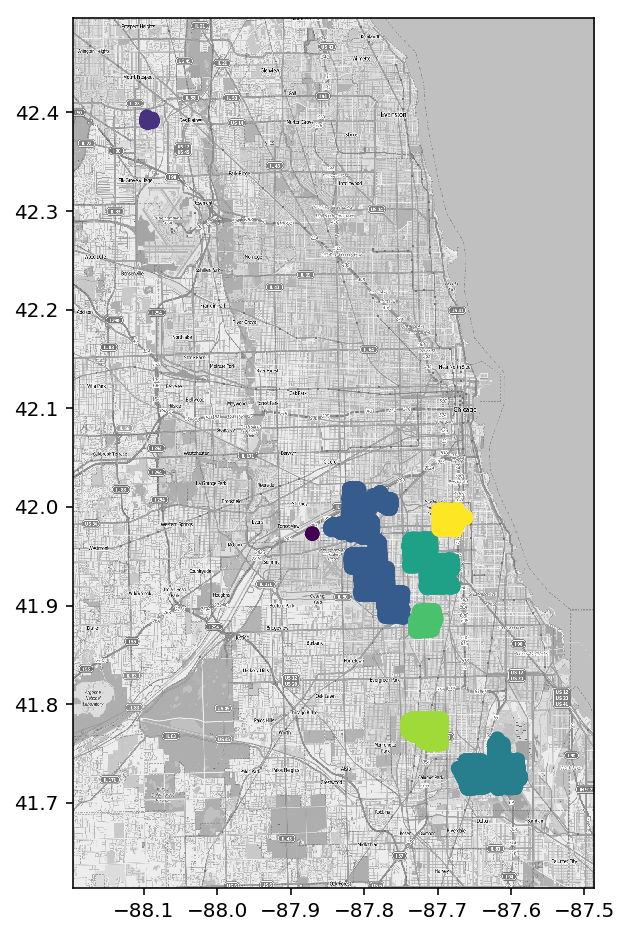

In [53]:
X_spray = spray_data[['Latitude', 'Longitude']]
spray_cluster_model = DBSCAN(eps=.01, min_samples=20).fit(X_spray)
spray_clusters = spray_cluster_model.labels_
X_spray['cluster'] = spray_clusters

lon_lat_box_spray = (X_spray['Longitude'].min()-.1, X_spray['Longitude'].max()+.1, X_spray['Latitude'].min()-.1,X_spray['Latitude'].max()+.1)

plt.figure(figsize=(5,8))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), aspect=aspect, extent=lon_lat_box_spray) 

plt.scatter(X_spray['Longitude'], X_spray['Latitude'], c=X_spray['cluster'], marker='o');

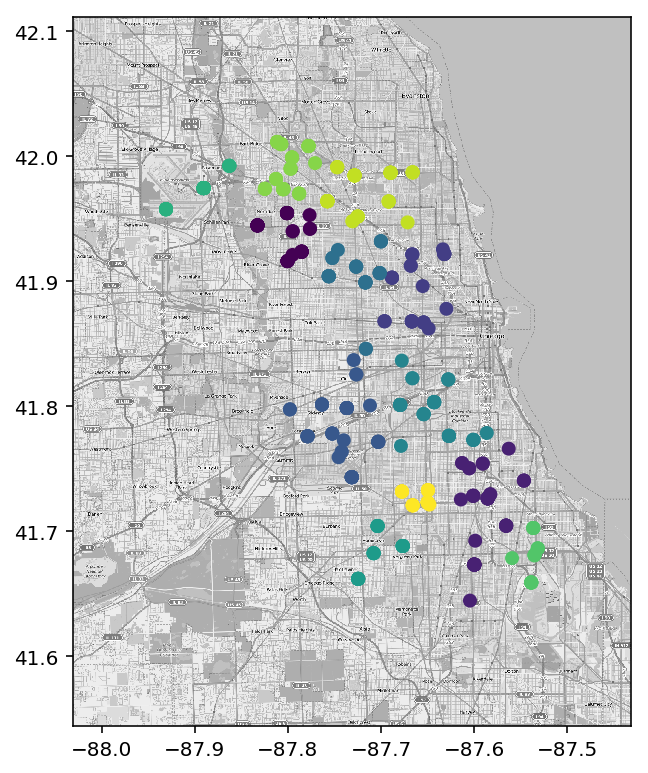

In [54]:
X_clusters = train_data[train_data['WnvPresent'] == 1][['Latitude', 'Longitude']]

cluster_model = KMeans(n_clusters=12).fit(X_clusters)
clusters = cluster_model.labels_
X_clusters['cluster'] = clusters

mapdata = np.loadtxt('mapdata_copyright_openstreetmap_contributors.txt')              

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (X_clusters['Longitude'].min()-.1, X_clusters['Longitude'].max()+.1, X_clusters['Latitude'].min()-.1,X_clusters['Latitude'].max()+.1)

plt.figure(figsize=(5,8))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), aspect=aspect, extent=lon_lat_box)
plt.scatter(X_clusters['Longitude'], X_clusters['Latitude'], c=X_clusters['cluster'], 
                marker='o');

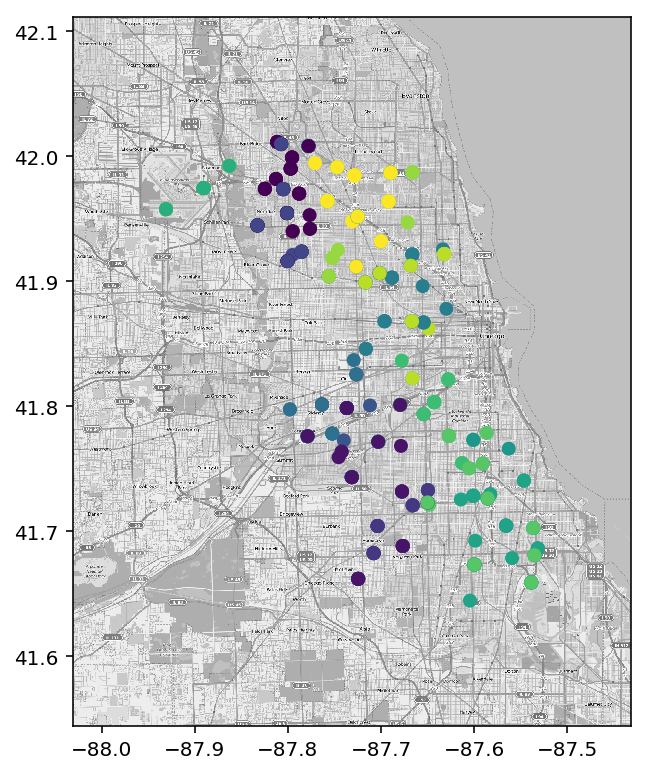

In [55]:
X_clusters_month = train_data[train_data['WnvPresent'] == 1][['month','Latitude', 'Longitude']]

cluster_month_model = KMeans(n_clusters=20).fit(X_clusters_month)
clusters_month = cluster_month_model.labels_
X_clusters_month['cluster'] = clusters_month

mapdata = np.loadtxt('mapdata_copyright_openstreetmap_contributors.txt')              

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (X_clusters_month['Longitude'].min()-.1, X_clusters_month['Longitude'].max()+.1, X_clusters_month['Latitude'].min()-.1,X_clusters_month['Latitude'].max()+.1)

plt.figure(figsize=(5,8))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), aspect=aspect, extent=lon_lat_box)
plt.scatter(X_clusters_month['Longitude'], X_clusters_month['Latitude'], c=X_clusters_month['cluster'], 
                marker='o');

<IPython.core.display.Javascript object>


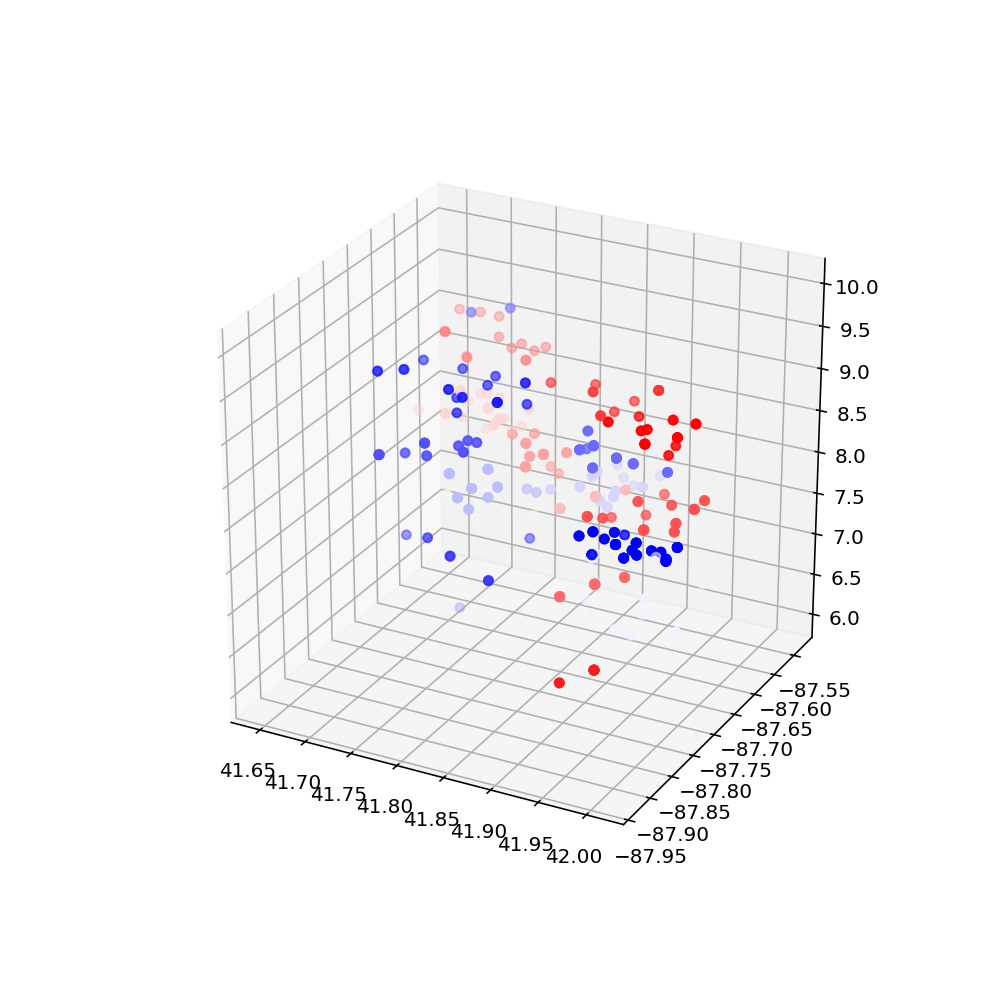

In [57]:
%matplotlib notebook
plt.figure(figsize=(7,7))
ax = plt.subplot(111, projection='3d')
ax.scatter(
    xs=X_clusters_month['Latitude'], 
    ys=X_clusters_month['Longitude'],
    zs=X_clusters_month['month'], 
    c=X_clusters_month['cluster'],
    cmap='bwr')

<IPython.core.display.Javascript object>


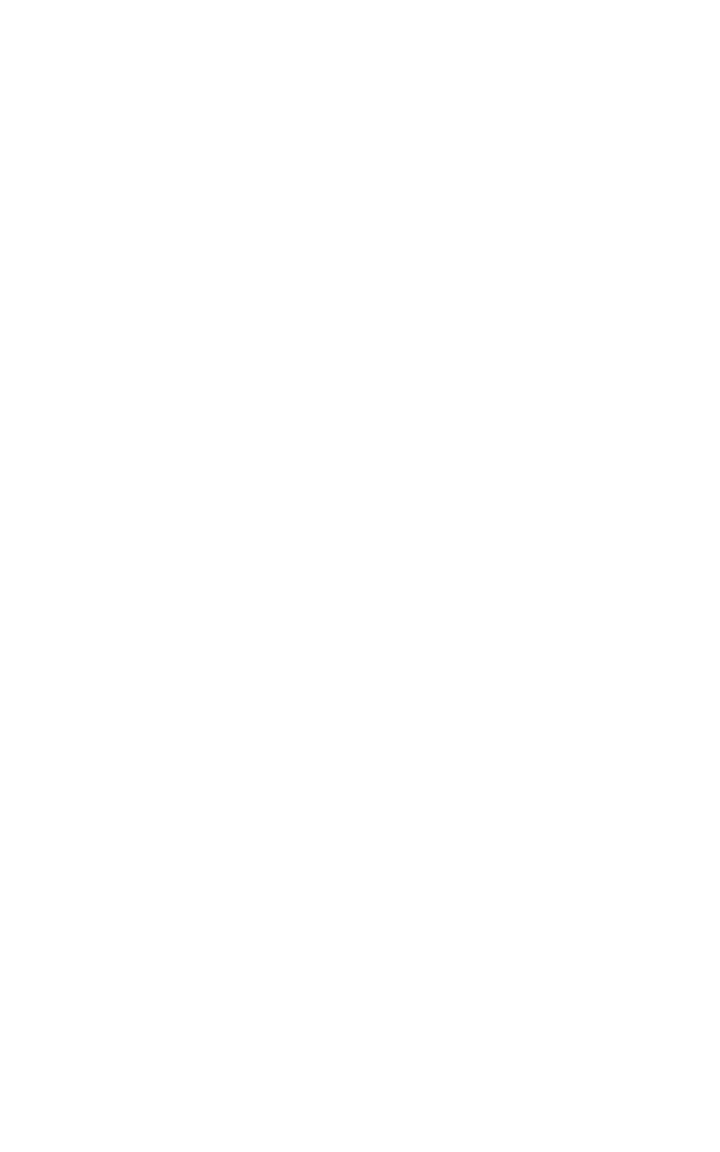

<IPython.core.display.Javascript object>


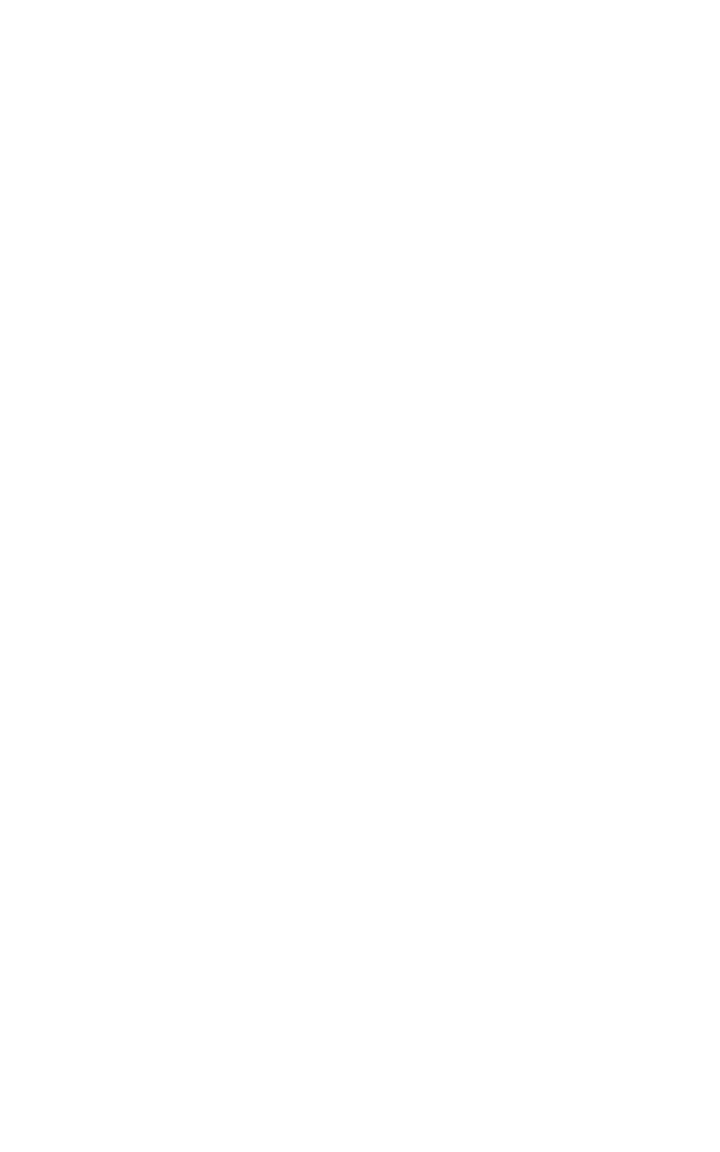

<IPython.core.display.Javascript object>


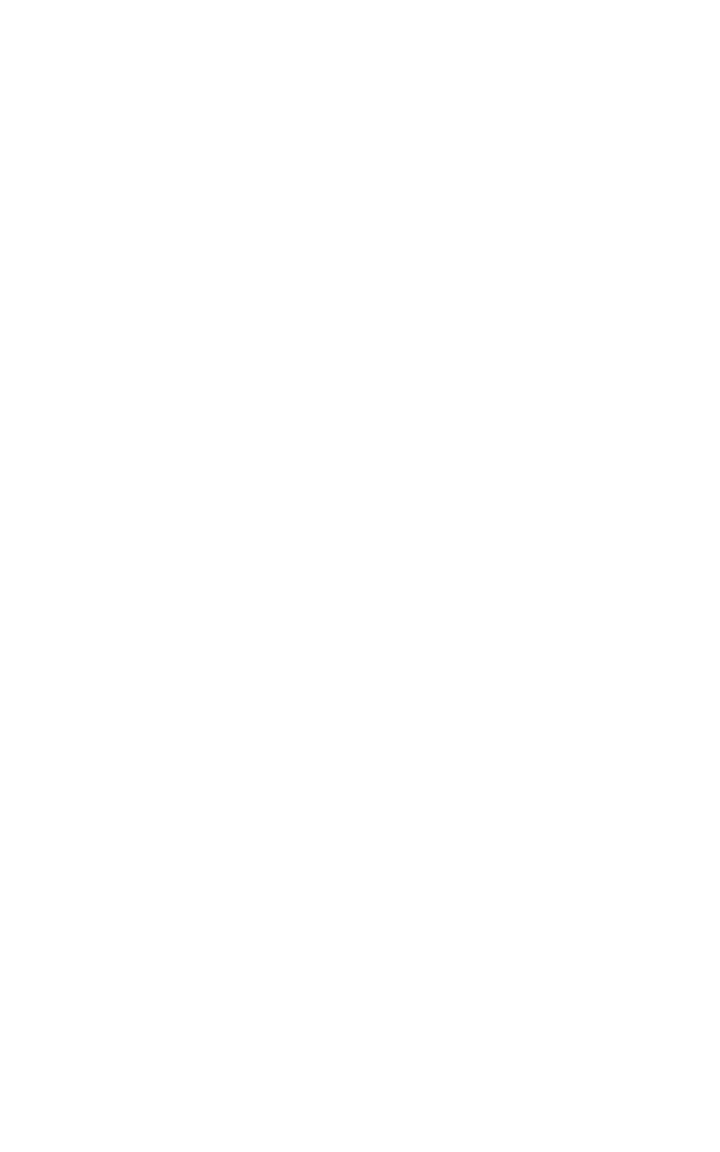

<IPython.core.display.Javascript object>


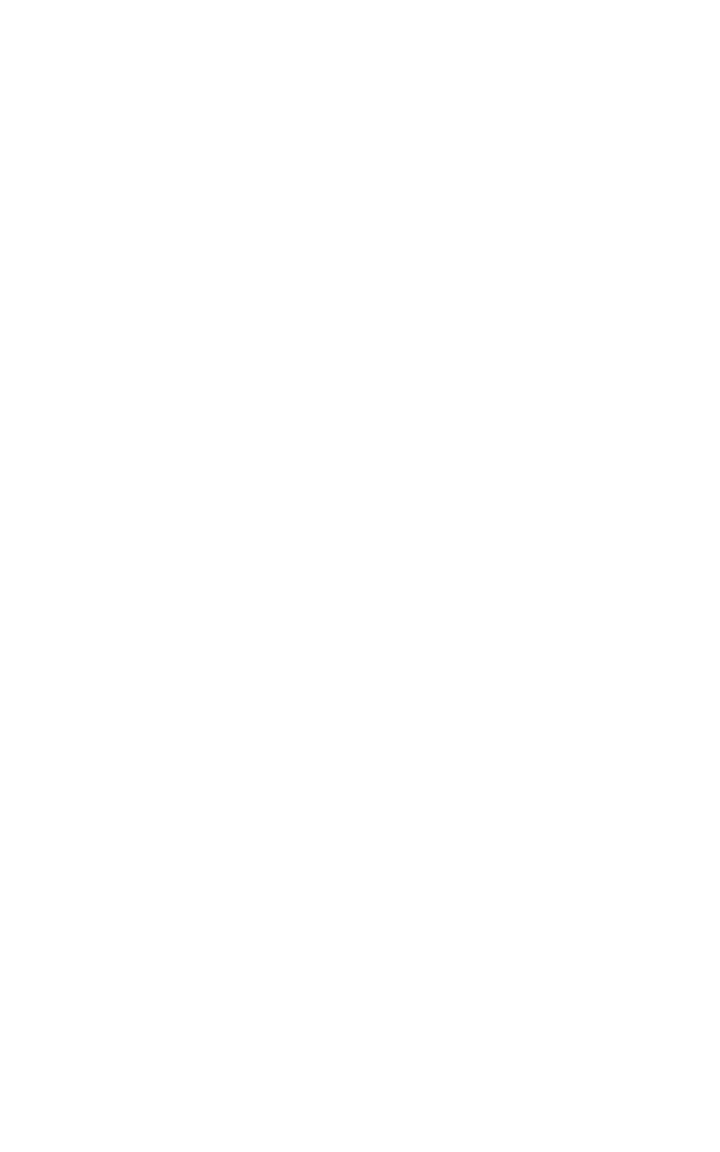

<IPython.core.display.Javascript object>


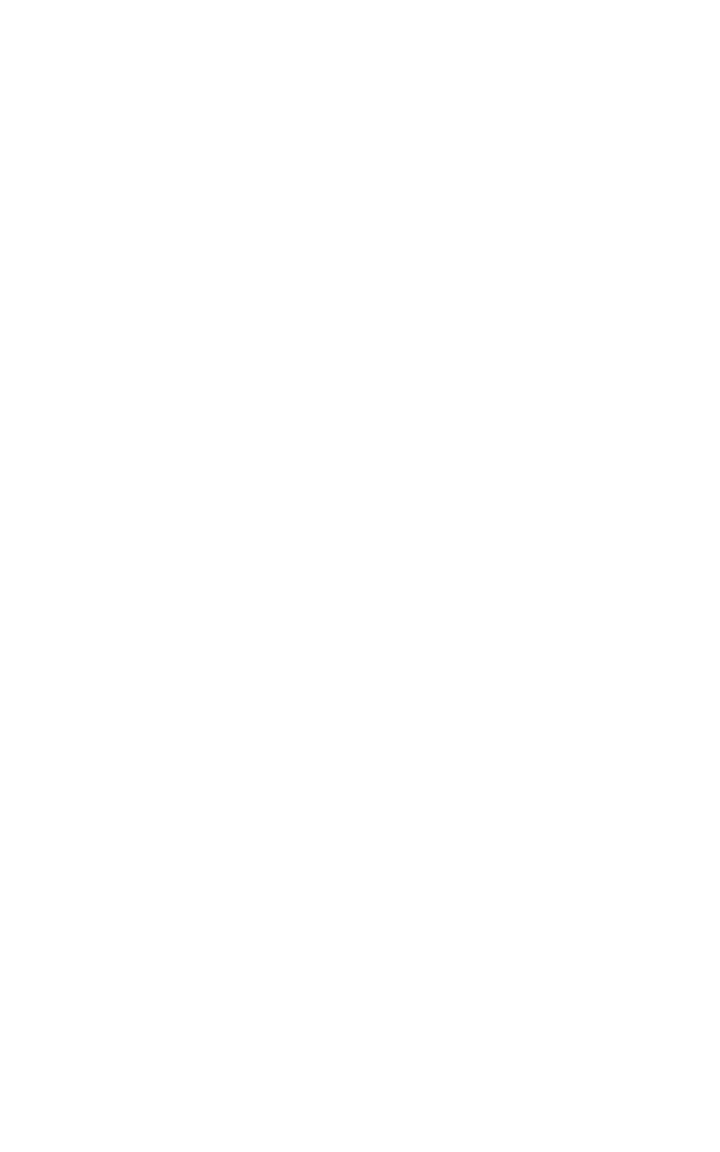

<IPython.core.display.Javascript object>


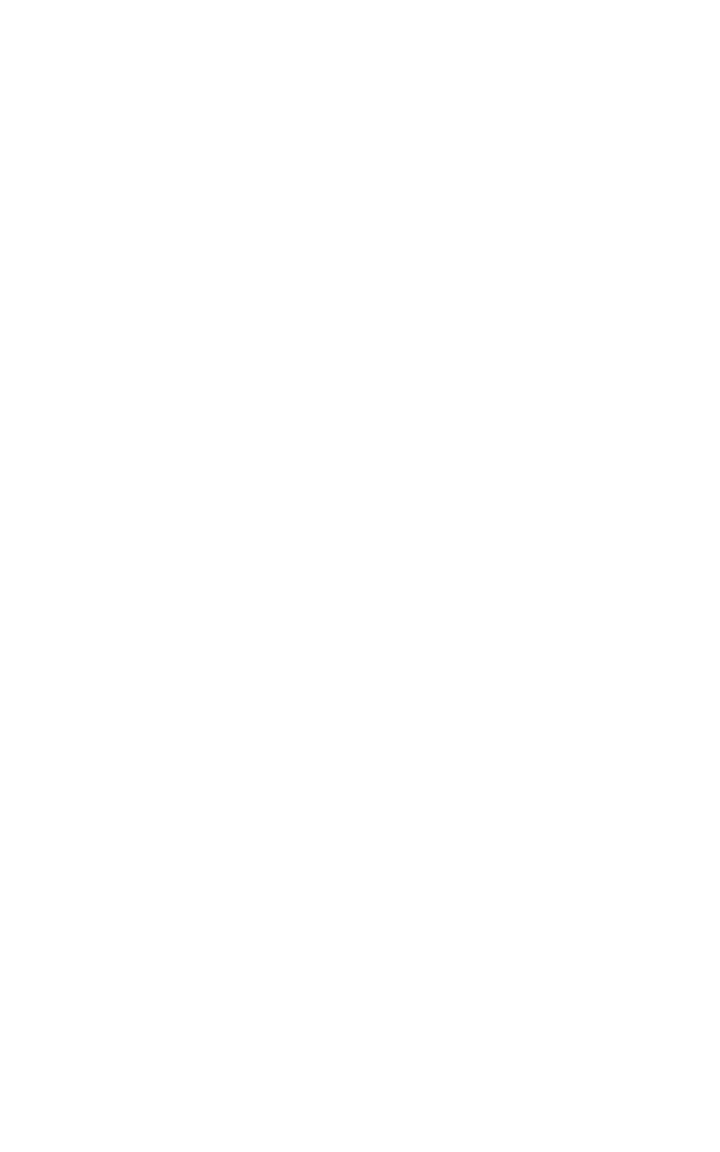

In [59]:
for i in train_data['month'].drop_duplicates().values:
    fig = plt.figure(figsize=(5,8))
    plt.imshow(mapdata, cmap=plt.get_cmap('gray'), aspect=aspect, extent=lon_lat_box)
    plt.title(i)
    plt.scatter(X_clusters_month[X_clusters_month['month'] == i]['Longitude'], 
                X_clusters_month[X_clusters_month['month'] == i]['Latitude'], 
                c=X_clusters_month[X_clusters_month['month'] == i]['cluster'], 
                marker='o')
    plt.savefig(f'month_{i}.png')
    plt.close(fig);

In [60]:
!convert -delay 50 month*.png movie2.gif

![](movie2.gif)

In [61]:
def add_clusters(df):
    df['cluster'] = cluster_model.predict(df[['Latitude', 'Longitude']])
    df['month_cluster'] = cluster_month_model.predict(df[['month','Latitude','Longitude']])

    X = X_spray[['Latitude', 'Longitude']]
    y = X_spray['cluster']
    rf1 = RandomForestClassifier()
    fit1 = rf1.fit(X, y)
    df['spray_cluster'] = fit1.predict(df[['Latitude','Longitude']])

    return df

train_data = add_clusters(train_data)
predict_data = add_clusters(predict_data)

In [62]:
cols_to_dummy = ['Species','Block','Street','Trap','month','week','cluster','spray_cluster','month_cluster']

def final_clean(df):
    for i in cols_to_dummy:
        df[i] = df[i].map((lambda x: i + '_' + str(x).replace(' ', '_')))
    return df

train_data = final_clean(train_data)
predict_data = final_clean(predict_data)

In [63]:
train_data.shape

(8610, 440)

In [64]:
train_data['WnvPresent'].value_counts(normalize=True)

0    0.946922
1    0.053078
Name: WnvPresent, dtype: float64

In [65]:
predict_data.set_index('Id',inplace=True)
predict_data.shape

(116293, 438)

In [66]:
assert [cols for cols in train_data.columns if cols not in predict_data.columns] == ['WnvPresent','NumMosquitos_sum']

# Create pipeline and model

In [68]:
train_data.drop(['Date', 'Address','AddressNumberAndStreet', 'NumMosquitos_sum'], axis=1, inplace=True)

In [69]:
class ModelTransformer(BaseEstimator,TransformerMixin):

    def __init__(self, model=None):
        self.model = model

    def fit(self, *args, **kwargs):
        self.model.fit(*args, **kwargs)
        return self

    def transform(self, X, **transform_params):
        return self.model.transform(X)
    
class SampleExtractor(BaseEstimator, TransformerMixin):
    """Takes in varaible names as a **list**"""

    def __init__(self, vars):
        self.vars = vars  # e.g. pass in a column names to extract

    def transform(self, X, y=None):
        if len(self.vars) > 1:
            return pd.DataFrame(X[self.vars]) # where the actual feature extraction happens
        else:
            return pd.Series(X[self.vars[0]])

    def fit(self, X, y=None):
        return self  # generally does nothing
    
    
class DenseTransformer(BaseEstimator,TransformerMixin):

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

In [70]:
species = Pipeline([
              ('text',SampleExtractor(['Species'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
block = Pipeline([
              ('text',SampleExtractor(['Block'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
street = Pipeline([
              ('text',SampleExtractor(['Street'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
trap = Pipeline([
              ('text',SampleExtractor(['Trap'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
month = Pipeline([
              ('text',SampleExtractor(['month'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
week = Pipeline([
              ('text',SampleExtractor(['week'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
cluster = Pipeline([
              ('text',SampleExtractor(['cluster'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
spray_cluster = Pipeline([
              ('text',SampleExtractor(['spray_cluster'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
month_cluster = Pipeline([
              ('text',SampleExtractor(['month_cluster'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])

In [71]:
X = train_data[[cols for cols in train_data.columns if cols != 'WnvPresent']]
y = train_data['WnvPresent']

cont_col_list = [cols for cols in X.columns if cols not in cols_to_dummy]

X_train, X_test, y_train, y_test, = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [72]:
pipeline_logreg = Pipeline([
    ('features', FeatureUnion([
        ('species', species),
        ('block', block),
        ('street', street),
        ('trap', trap),
        ('month', month),
        ('week', week),
        ('cluster',cluster),
        ('spray_cluster',spray_cluster),
        ('month_cluster',month_cluster),
        ('cont_features', Pipeline([
                      ('continuous', SampleExtractor(cont_col_list)),
                      ])),
        ])),
        ('scale', ModelTransformer()),
        ('sm', SMOTE(ratio='minority', random_state=240)),
        ('lr', LogisticRegression()),
])


params_logreg = {
    'scale__model': [StandardScaler(), MinMaxScaler()],
    'lr__penalty':['l1','l2'],
    'lr__C':[.01,0.03,.05],
    'lr__class_weight':[None,'balanced']
}
    

gs1 = GridSearchCV(pipeline_logreg,param_grid=params_logreg, scoring='roc_auc', n_jobs=-1)
gs1.fit(X_train,y_train)
print('best cv score', gs1.best_score_)
print('best paramas', gs1.best_params_)
print('test score', gs1.score(X_test, y_test))

best cv score 0.8126109108641119
best paramas {'lr__C': 0.03, 'lr__class_weight': None, 'lr__penalty': 'l1', 'scale__model': MinMaxScaler(copy=True, feature_range=(0, 1))}
test score 0.8654536756927927


In [73]:
model_logreg = gs1.best_estimator_
model_logreg.fit(X, y)
test_pred = model_logreg.predict_proba(predict_data)
test_pred = pd.DataFrame(test_pred)
test_pred['Id'] = [i for i in range(1,116294)]
test_pred.rename({1:'WnvPresent'}, axis=1, inplace=True)
test_pred.drop([0],axis=1,inplace=True)

In [74]:
feature_names = []
for i in [species, block, street,trap,month, week, cluster, spray_cluster,month_cluster]:
    feature_names.append(i.fit(train_data).steps[1][1].get_feature_names())

columns_list = [i for i in X.columns if i not in cols_to_dummy]

feature_names.append(columns_list)

feature_names = [i for j in feature_names for i in j]

coef = pd.DataFrame(feature_names, model_logreg.steps[3][1].coef_.tolist(),columns=['Feature'])
coef.reset_index(inplace=True)

coef.rename({'level_0':'Coefficient'}, axis=1, inplace=True)

coef['abs'] = coef['Coefficient'].abs()
coef50 = coef.sort_values(by='abs',ascending=False)[:50]
coef50

,Coefficient,Feature,abs
412,-4.217283,time_since_max_wnvpresent,4.217283
402,1.163883,year,1.163883
658,1.152250,SeaLevel_shift_7,1.152250
353,1.115628,week_36,1.115628
354,1.103759,week_37,1.103759
399,-1.046141,Longitude,1.046141
2,1.033282,species_culex_pipiens,1.033282
665,-0.985192,Tmax_shift_8,0.985192
785,-0.881603,ResultSpeed_shift_14,0.881603
714,-0.730839,ResultDir_shift_10,0.730839


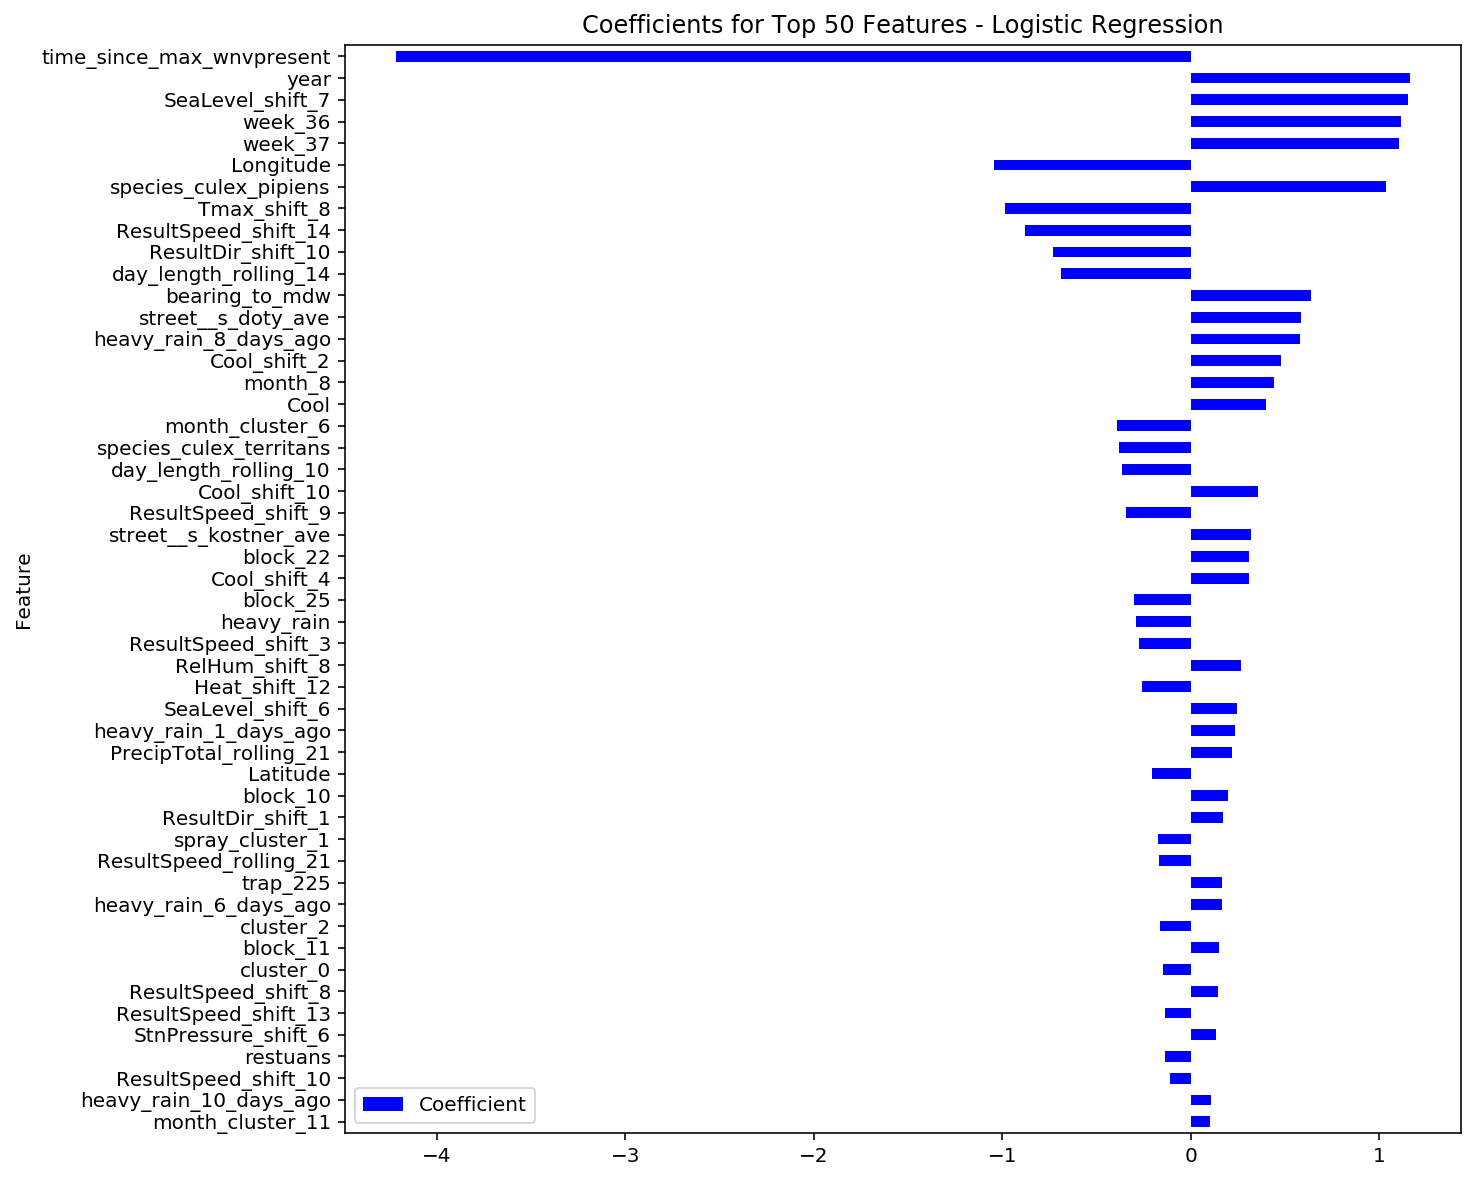

In [75]:
%matplotlib inline
coef50.sort_values(by='abs').plot(y='Coefficient',x='Feature',kind='barh', figsize=(10,10), color='b', 
                                  title='Coefficients for Top 50 Features - Logistic Regression');

In [ ]:
pipeline_rf = Pipeline([
    ('features', FeatureUnion([
        ('species', species),
        ('block', block),
        ('street', street),
        ('trap', trap),
        ('month', month),
        ('week', week),
        ('cluster',cluster),
        ('spray_cluster',spray_cluster),
        ('cont_features', Pipeline([
                      ('continuous', SampleExtractor(cont_col_list)),
                      ])),
        ])),
        ('scale', ModelTransformer()),
        ('sm', SMOTE(ratio='minority',random_state=240)),
        ('rf', RandomForestClassifier()),
])


params_rf = {
    'scale__model': [StandardScaler(), MinMaxScaler()],
    'rf__n_estimators':[50, 100, 150],
    'rf__max_features':['auto', 'log2', None],
    'rf__max_depth':[10,30,None]
}
    

gs3 = GridSearchCV(pipeline_rf,param_grid=params_rf, scoring='roc_auc')
gs3.fit(X_train,y_train)
print('best cv score', gs3.best_score_)
print('best paramas', gs3.best_params_)
print('test score', gs3.score(X_test, y_test))

In [ ]:
model_rf = gs3.best_estimator_
model_rf.fit(X, y)
test_pred3 = model_rf.predict_proba(predict_data)
test_pred3 = pd.DataFrame(test_pred3)
test_pred3['Id'] = [i for i in range(1,116294)]
test_pred3.rename({1:'WnvPresent'}, axis=1, inplace=True)
test_pred3.drop([0],axis=1,inplace=True)
test_pred3.to_csv('test_pred_45.csv',index=False)

# Wnv Presence Movie Making

In [47]:
mapdata = np.loadtxt('mapdata_copyright_openstreetmap_contributors.txt')  
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (train_data['Longitude'].min()-.1, train_data['Longitude'].max()+.1, train_data['Latitude'].min()-.1, train_data['Latitude'].max()+.1)

for j in train_data['year'].drop_duplicates().values:
    for i in train_data['month'].drop_duplicates().values:
        fig = plt.figure(figsize=(5,8))
        plt.imshow(mapdata, cmap=plt.get_cmap('gray'), aspect=aspect, extent=lon_lat_box)
        plt.title('month_' + str(i) + ', '+ str(j))
        
        plt.scatter(train_data[(train_data['month'] == i) & (train_data['year'] == j)]['Longitude'], 
                    train_data[(train_data['month'] == i) & (train_data['year'] == j)]['Latitude'], 
                    c=train_data[(train_data['month'] == i) & (train_data['year'] == j)]['WnvPresent'],
                    marker='o')
                
        plt.savefig(f'wnv_{i,j}.png')
        plt.close(fig);

In [49]:
!convert -delay 50 wnv*.png movie3.gif